# ENSEMBLE MODELS AND BOOSTING

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# игнорировать предупреждения
import warnings
warnings.filterwarnings("ignore")


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [15]:
from sklearn.metrics import auc, roc_curve


### Bagging

## Task

BNP Paribas
https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/data

The problem of classification of insured events is being solved:
     1. Cases requiring additional documents for confirmation (0)
     2. Cases that can be confirmed automatically based on available information (1)

In [16]:
data = pd.read_csv('Paribas.csv')
data

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114316,228708,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,AL,NaN,NaN,NaN,0,NaN,NaN
114317,228710,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,E,NaN,NaN,NaN,1,NaN,NaN
114318,228711,1,NaN,NaN,C,NaN,10.069277,NaN,NaN,0.323324,...,NaN,NaN,0.156764,Q,NaN,NaN,2.417606,2,NaN,NaN
114319,228712,1,NaN,NaN,C,NaN,10.106144,NaN,NaN,0.309226,...,NaN,NaN,0.490658,BW,NaN,NaN,3.526650,0,NaN,NaN


In [17]:
data.shape

(114321, 133)

#### Reducing the size of the data to speed up training, we take a random subsample of 10% of the data with stratification

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

random_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=777)

for train_index, test_index in random_splitter.split(data, data.target):
    data = data.iloc[test_index]

In [19]:
data.shape

(11433, 133)

In [20]:
X = data.drop(columns=['target'], axis=1)
y = data['target']


## Primary analysis

In [21]:
X.shape

(11433, 132)

Распределение значений таргета (event rate)

In [22]:
y.value_counts() / len(data)

1    0.761218
0    0.238782
Name: target, dtype: float64

## Preproccessing

Finding categorical signs

In order not to significantly increase the number of features when constructing a dummy, we will use categorical features with <30 unique values

In [23]:
cat_feat = list(X.dtypes[X.dtypes == object].index)

X[cat_feat] = X[cat_feat].fillna('nan')

# filter continuous signs
num_feat = [f for f in X if f not in (cat_feat + ['ID'])]

cat_nunique = X[cat_feat].nunique()
print(cat_nunique)
cat_feat = list(cat_nunique[cat_nunique < 30].index)  

v3         4
v22     5282
v24        5
v30        8
v31        4
v47        9
v52       12
v56       85
v66        3
v71        4
v74        3
v75        4
v79       17
v91        7
v107       7
v110       3
v112      23
v113      35
v125      89
dtype: int64


In [24]:
X_median = X[num_feat].median()

In [25]:
dummy_X = pd.get_dummies(X[cat_feat], columns=cat_feat)

In [26]:
X_new = pd.concat([X[num_feat].fillna(X_median),
                     X[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_X], axis=1)

In [27]:
scaler = StandardScaler()
scaler.fit(X_new)

StandardScaler()

In [28]:
X_norm = scaler.transform(X_new )
X_norm = pd.DataFrame(X_norm, columns = X_new.columns)
X_norm

,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,...,v112_N,v112_O,v112_P,v112_Q,v112_R,v112_S,v112_T,v112_U,v112_V,v112_nan
0,-0.115656,-0.110734,0.049622,-0.014220,-0.025537,-0.039931,-0.291989,0.023024,2.364536,0.050690,...,-0.288771,-0.182879,-0.205903,-0.145179,-0.192372,-0.087567,-0.185418,-0.204746,-0.126474,-0.058505
1,-0.115656,-0.110734,0.049622,-0.014220,-0.025537,-0.039931,-0.291989,0.023024,0.237076,0.050690,...,-0.288771,-0.182879,-0.205903,-0.145179,-0.192372,-0.087567,-0.185418,-0.204746,-0.126474,-0.058505
2,-0.115656,-0.110734,0.049622,-0.014220,-0.025537,-0.039931,-0.291989,0.023024,-0.042444,0.050690,...,-0.288771,-0.182879,-0.205903,-0.145179,-0.192372,-0.087567,-0.185418,-0.204746,-0.126474,-0.058505
3,-0.115656,-0.110734,0.049622,-0.014220,-0.025537,-0.039931,-0.291989,0.023024,-0.601485,0.050690,...,-0.288771,-0.182879,-0.205903,-0.145179,-0.192372,-0.087567,5.393222,-0.204746,-0.126474,-0.058505
4,0.456383,-1.864827,-2.733508,0.361596,-1.837098,-0.960866,4.182560,0.315959,-0.989707,-0.698702,...,-0.288771,-0.182879,-0.205903,-0.145179,-0.192372,-0.087567,-0.185418,-0.204746,-0.126474,-0.058505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11428,-0.953522,-0.028416,-0.810500,0.065843,-1.401714,-0.909662,-0.372172,-0.301733,0.516596,0.897709,...,-0.288771,-0.182879,-0.205903,-0.145179,-0.192372,-0.087567,-0.185418,-0.204746,-0.126474,-0.058505
11429,-0.115656,-0.110734,0.049622,-0.014220,-0.025537,-0.039931,-0.291989,0.023024,-0.601484,0.050690,...,3.462953,-0.182879,-0.205903,-0.145179,-0.192372,-0.087567,-0.185418,-0.204746,-0.126474,-0.058505
11430,-0.115656,-0.110734,0.049622,-0.450420,-0.025537,-0.039931,4.819586,0.023024,0.951405,0.050690,...,-0.288771,-0.182879,-0.205903,-0.145179,-0.192372,-0.087567,-0.185418,-0.204746,-0.126474,-0.058505
11431,-0.284738,0.433398,0.451999,-1.493662,-1.013645,2.297168,-0.447640,0.474049,-0.415137,-1.290703,...,-0.288771,-0.182879,-0.205903,6.888027,-0.192372,-0.087567,-0.185418,-0.204746,-0.126474,-0.058505


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

#### Function for calculate ROC AUC and shareing plot

In [30]:
def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

In [31]:
y_train

29102    1
32602    1
53970    1
34180    1
27712    0
        ..
97527    1
6034     1
7371     1
64506    1
51666    1
Name: target, Length: 9146, dtype: int64

### LOG_REG

In [32]:
clf_lr = LogisticRegression(penalty='l2', C=0.01, random_state=42)

clf_lr.fit(X_train, y_train)

LogisticRegression(C=0.01, random_state=42)

Train:
ROC AUC: 0.7396
Test:
ROC AUC: 0.7090


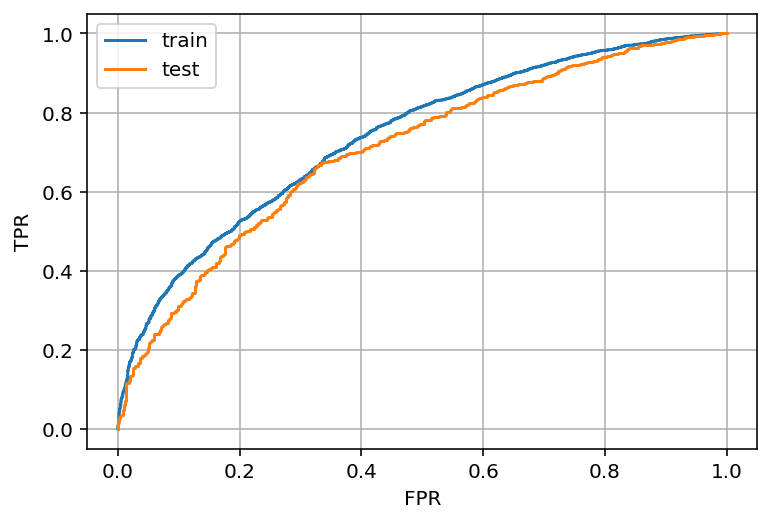

In [33]:
y_pred_lin_test = clf_lr.predict_proba(X_test)[:, 1]
y_pred_lin_train = clf_lr.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_lin_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_lin_test, 'test')
plt.grid()

plt.legend();

### Decsion Tree


In [34]:
clf_tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)

Train:
ROC AUC: 0.7397
Test:
ROC AUC: 0.6969


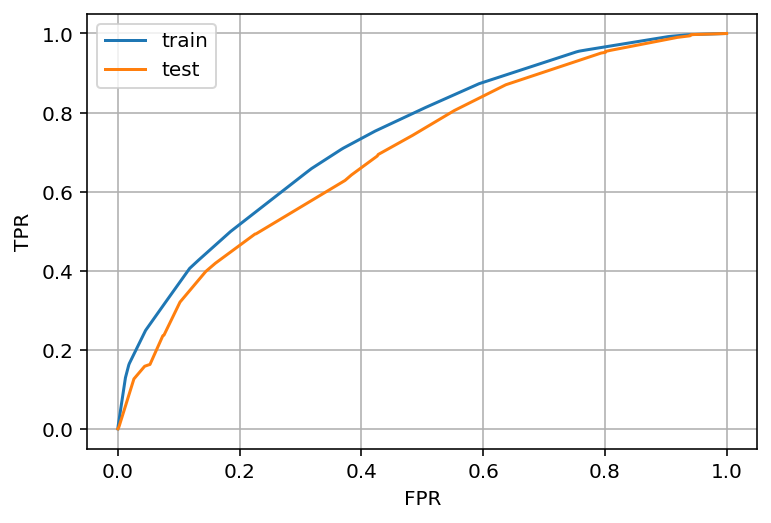

In [35]:
y_pred_train_tr = clf_tree.predict_proba(X_train)[:, 1]
y_pred_test_tr = clf_tree.predict_proba(X_test)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_train_tr, 'train')
print('Test:')
calc_auc(y_test, y_pred_test_tr, 'test')
plt.grid()
plt.legend();

### Voting

In [36]:
from sklearn.ensemble import VotingClassifier

In [37]:
voting_clf = VotingClassifier(
    estimators=[('DTree', clf_tree), ('LogR', clf_lr)], voting='soft', n_jobs=-1) 

In [38]:
%%time
voting_clf.fit(X_train, y_train)

Wall time: 2.13 s


VotingClassifier(estimators=[('DTree',
                              DecisionTreeClassifier(max_depth=5,
                                                     min_samples_leaf=10,
                                                     random_state=42)),
                             ('LogR',
                              LogisticRegression(C=0.01, random_state=42))],
                 n_jobs=-1, voting='soft')

Train:
ROC AUC: 0.7545
Test:
ROC AUC: 0.7153


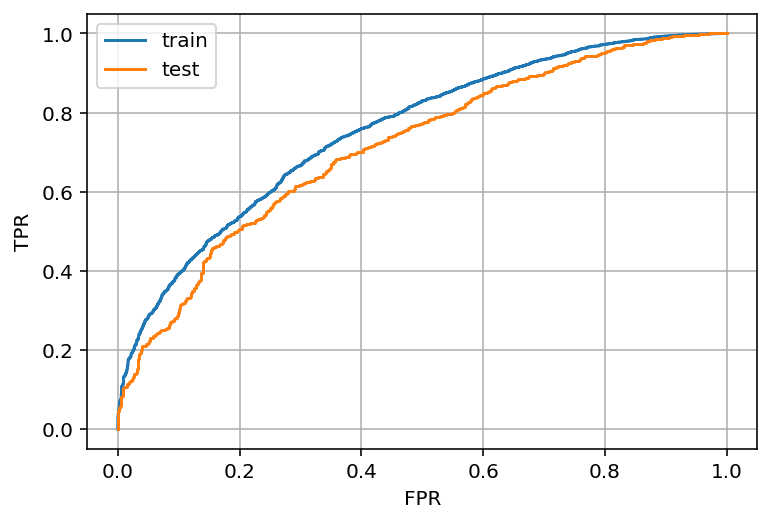

In [39]:
y_pred_test_vot = voting_clf.predict_proba(X_test)[:, 1]
y_pred_train_vot = voting_clf.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_train_vot, 'train')
print('Test:')
calc_auc(y_test, y_pred_test_vot, 'test')
plt.grid()
plt.legend();

## Composition of model from 1 class

### BAGGING

Tree

In [40]:
%%time
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(n_estimators=20, base_estimator=clf_tree, n_jobs=-1, max_features=0.8, random_state=42)
bag_clf.fit(X_train, y_train)

Wall time: 2.29 s


BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                        min_samples_leaf=10,
                                                        random_state=42),
                  max_features=0.8, n_estimators=20, n_jobs=-1,
                  random_state=42)

Train:
ROC AUC: 0.7684
Test:
ROC AUC: 0.7057


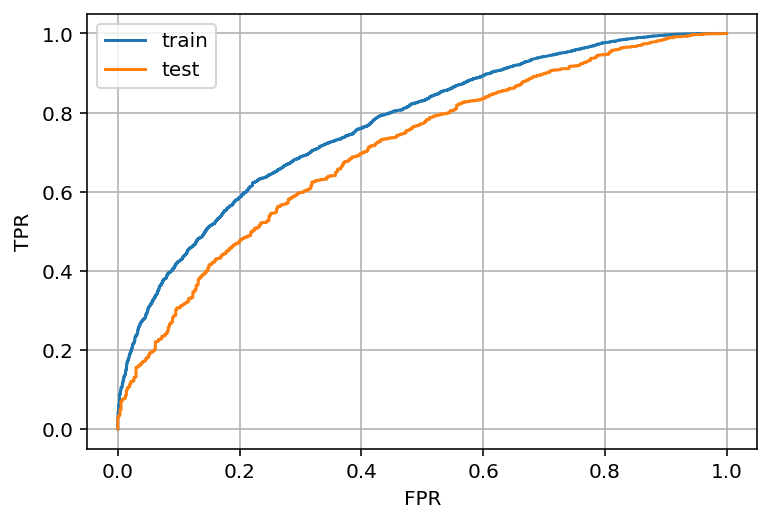

In [41]:
y_pred_test_bg = bag_clf.predict_proba(X_test)[:, 1]
y_pred_train_bg = bag_clf.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_train_bg, 'train')
print('Test:')
calc_auc(y_test, y_pred_test_bg, 'test')
plt.grid()
plt.legend();

##### LogisticRegr

In [42]:
%%time
bag_clf_lr = BaggingClassifier(n_estimators=20, base_estimator=clf_lr, n_jobs=-1, random_state=42)
bag_clf_lr.fit(X_train, y_train)

Wall time: 7.72 s


BaggingClassifier(base_estimator=LogisticRegression(C=0.01, random_state=42),
                  n_estimators=20, n_jobs=-1, random_state=42)

Train:
ROC AUC: 0.7392
Test:
ROC AUC: 0.7083


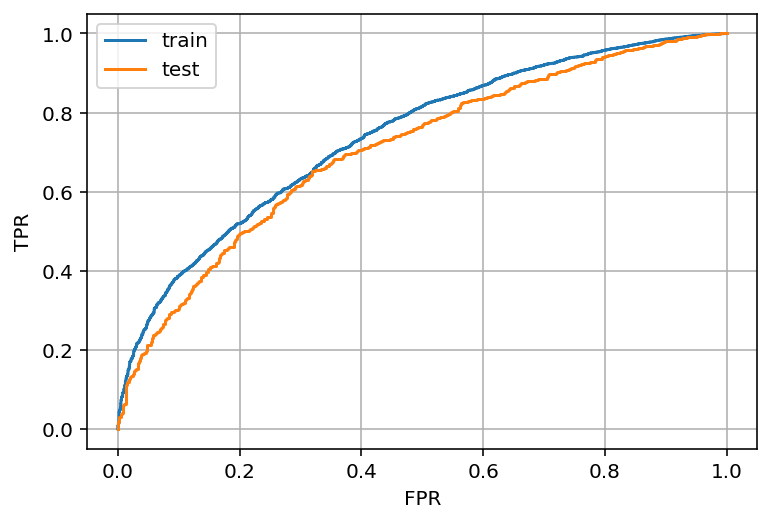

In [43]:
y_pred_test_bgLR = bag_clf_lr.predict_proba(X_test)[:, 1]
y_pred_train_bgLR = bag_clf_lr.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_train_bgLR, 'train')
print('Test:')
calc_auc(y_test, y_pred_test_bgLR, 'test')
plt.grid()
plt.legend();

# RandomForest


** Important hyperparameters of the algorithm **

a. Tree parameters
    1.criterion - criterion for building a tree
    2.max_depth - maximum tree depth (usually 10-20, more depth -> more risk of overfitting)
    3.min_samples_leaf - the minimum number of objects in a sheet (usually 20+, more objects -> less risk of overfitting)

b. Forest parameters
    1.n_estimators - number of trees (the more the better)
    2.max_features - number of features of a random subspace
    3.bootstrap - whether to use bagging
    4.n_jobs - the number of threads for the simultaneous construction of trees (a large increase in speed on multi-core CPUs)

In [44]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_split=14, random_state=42, 
                                criterion='entropy', min_samples_leaf=20, max_features=0.8, n_jobs=-1)

clf_rf.fit(X_train, y_train)    

Wall time: 11.9 s


RandomForestClassifier(criterion='entropy', max_depth=7, max_features=0.8,
                       min_samples_leaf=20, min_samples_split=14, n_jobs=-1,
                       random_state=42)

Train:
ROC AUC: 0.8151
Test:
ROC AUC: 0.7044


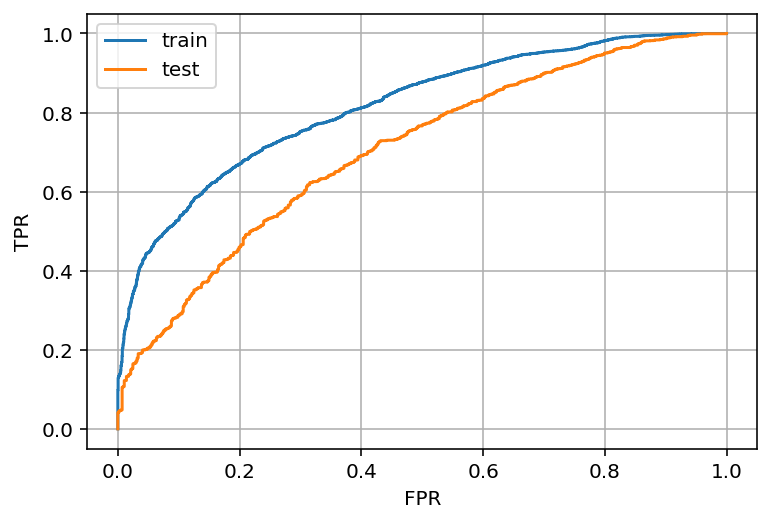

In [45]:
y_pred_rf_test = clf_rf.predict_proba(X_test)[:, 1]
y_pred_rf_train = clf_rf.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_rf_train , 'train')
print('Test:')
calc_auc(y_test, y_pred_rf_test, 'test')
plt.grid()
plt.legend();

#### feature_importances_

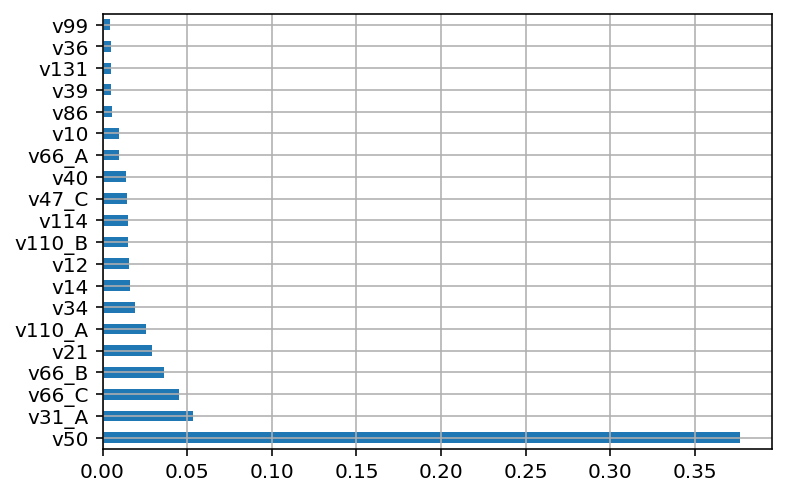

In [46]:
imp = pd.Series(clf_rf.feature_importances_, index=X_norm.columns).sort_values(ascending=False).iloc[:20].plot(kind='barh')
plt.grid();

#### ExtraTreesClassifier

In [47]:
from sklearn.ensemble import ExtraTreesClassifier

In [48]:
clf_Erf = ExtraTreesClassifier(n_estimators=100, max_depth=7, min_samples_split=14, random_state=42, 
                                criterion='entropy', min_samples_leaf=20, max_features=0.8, n_jobs=-1)

In [49]:
%%time
clf_Erf.fit(X_train, y_train)

Wall time: 4.64 s


ExtraTreesClassifier(criterion='entropy', max_depth=7, max_features=0.8,
                     min_samples_leaf=20, min_samples_split=14, n_jobs=-1,
                     random_state=42)

Train:
ROC AUC: 0.7819
Test:
ROC AUC: 0.7123


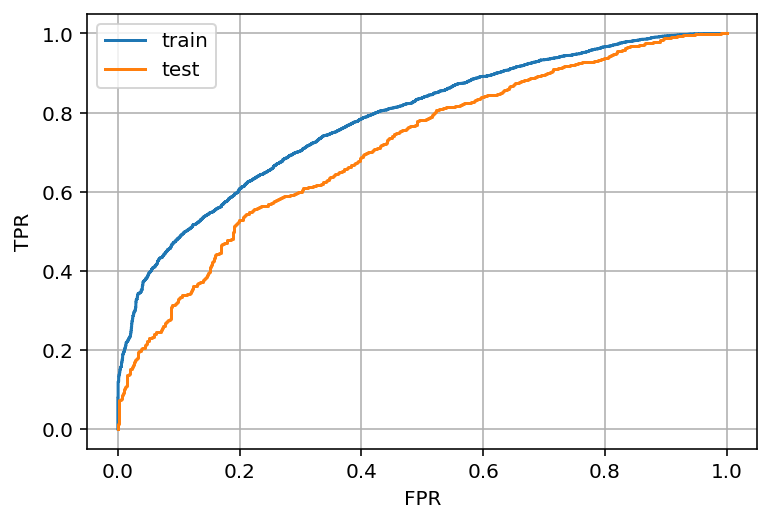

In [50]:
y_pred_Erf_test = clf_Erf.predict_proba(X_test)[:, 1]
y_pred_Erf_train = clf_Erf.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_Erf_train , 'train')
print('Test:')
calc_auc(y_test, y_pred_Erf_test, 'test')
plt.grid()
plt.legend();

# Compositions of models of different types

### Linear combination of models

we will mix lr and dt


$y = \alpha y_1 + (1 - \alpha) y_2$

$\alpha$ from 0 to 1

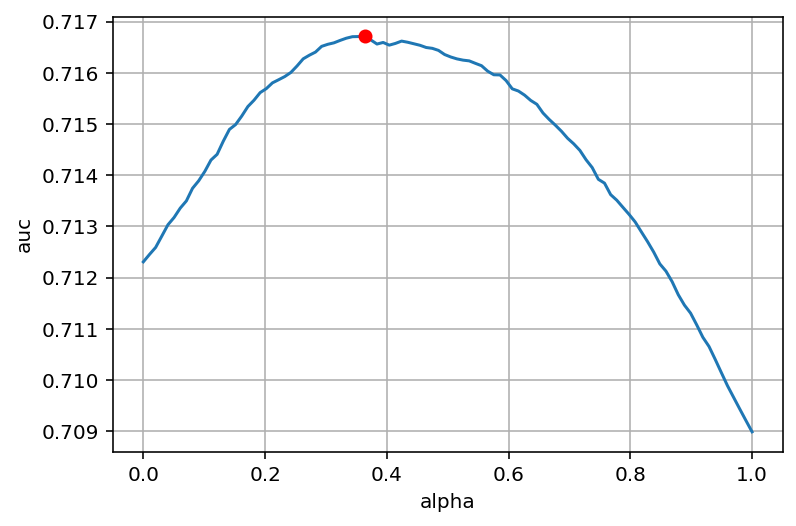

In [51]:
aucs = []
alpha_space = np.linspace(0, 1, 100)
for alpha in alpha_space:
    y_pred_weight = alpha * y_pred_lin_test + (1 - alpha) * y_pred_Erf_test
    aucs.append(calc_auc(y_test, y_pred_weight, prin=False))
aucs = np.array(aucs)    

max_ind = np.where(aucs == aucs.max())[0]
alpha = alpha_space[max_ind]

plt.plot(alpha_space, aucs)
plt.plot(alpha_space[max_ind], aucs[max_ind], 'o', c='r')
plt.xlabel('alpha')
plt.ylabel('auc')
plt.grid()

# result mixed prediction
y_pred_weight = alpha * y_pred_lin_test + (1 - alpha) * y_pred_Erf_test

Weighted:
ROC AUC: 0.7167
Log regression:
ROC AUC: 0.7090
ExtraTrees:
ROC AUC: 0.7123


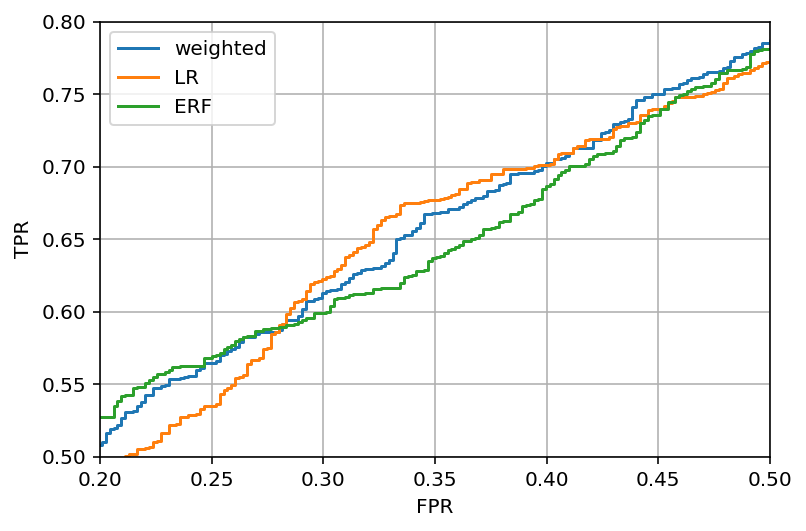

In [52]:
print('Weighted:')
calc_auc(y_test, y_pred_weight, 'weighted')
print('Log regression:')
calc_auc(y_test, y_pred_lin_test, 'LR')
print('ExtraTrees:')
calc_auc(y_test, y_pred_Erf_test, 'ERF')
plt.legend();
plt.xlim(0.2, 0.5)
plt.ylim(0.5, 0.8)
plt.grid();

### StackingClassifier

In [53]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline

In [54]:
estimators = [
            ('rf', clf_rf),
            ('Etree', clf_Erf),
            ('Bagg',bag_clf)
            ]

In [55]:
Stac_clf = StackingClassifier(estimators=estimators, 
                              final_estimator=clf_Erf, n_jobs=-1, verbose=3)

In [56]:
%%time
Stac_clf.fit(X_train, y_train)

Wall time: 1min 36s


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=7,
                                                       max_features=0.8,
                                                       min_samples_leaf=20,
                                                       min_samples_split=14,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('Etree',
                                ExtraTreesClassifier(criterion='entropy',
                                                     max_depth=7,
                                                     max_features=0.8,
                                                     min_samples_leaf=20,
                                                     min_samples_split=14,
                                                   

Train:
ROC AUC: 0.7954
Test:
ROC AUC: 0.7160


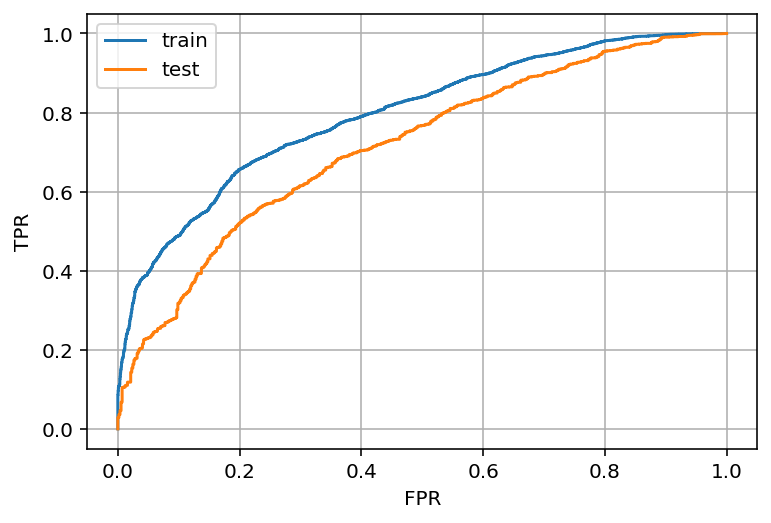

In [57]:
y_pred_Stac_test = Stac_clf.predict_proba(X_test)[:, 1]
y_pred_Stac_train = Stac_clf.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_Stac_train , 'train')
print('Test:')
calc_auc(y_test, y_pred_Stac_test, 'test')
plt.grid()
plt.legend();

## boosting from sklearn

In [58]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

#### Adaboost

Train:
ROC AUC: 0.7677
Test:
ROC AUC: 0.7005
Wall time: 14.5 s


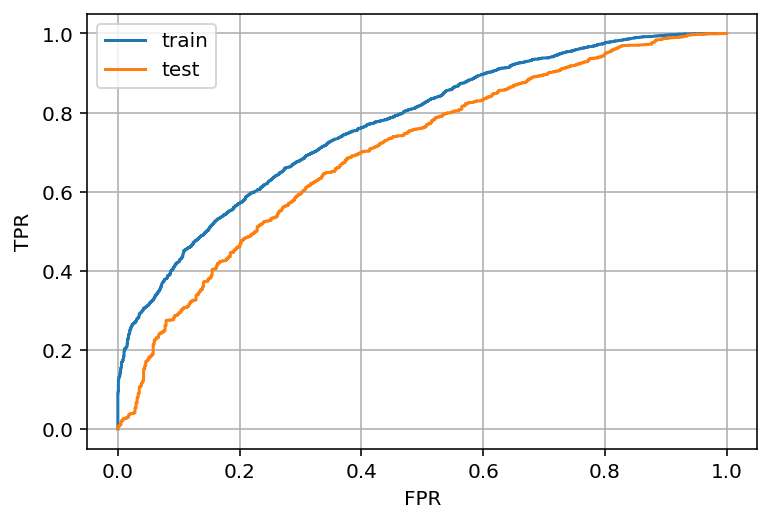

In [59]:
%%time
clf_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, min_samples_leaf=30, max_features=0.8, min_samples_split=30),
                             n_estimators=100, learning_rate=0.1, random_state=42)

clf_ada.fit(X_train, y_train)
y_pred_ada_test = clf_ada.predict_proba(X_test)[:, 1]
y_pred_ada_train = clf_ada.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_ada_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_ada_test, 'test')
plt.grid();
plt.legend();

#### GradientBoosting

Train:
ROC AUC: 0.7610
Test:
ROC AUC: 0.7103
Wall time: 10.6 s


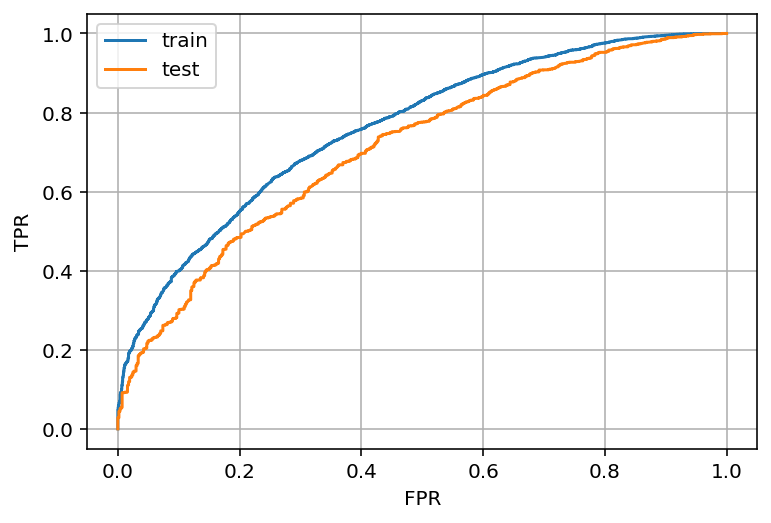

In [60]:
%%time
clf_gbm = GradientBoostingClassifier(max_depth=2, min_samples_leaf=30, n_estimators=100, learning_rate=0.1, 
                                     subsample=1.0, max_features=0.8, min_samples_split=30, random_state=42, 
                                     verbose=0)
# if subsample <1.0 - you get a stochastic gradient descent, the algorithm will work faster,
# but accuracy may be worse

clf_gbm.fit(X_train, y_train)
y_pred_gbm_test = clf_gbm.predict_proba(X_test)[:, 1]
y_pred_gbm_train = clf_gbm.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_gbm_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_gbm_test, 'test')
plt.legend()
plt.grid();

## XGBOOST

In [61]:
import xgboost as xgb

**important params**
a. Tree parameters

    1.max_depth - maximum tree depth (usually 3-10, more depth -> more risk of overfitting)
    2.min_child_weight - the minimum number of objects in a sheet (usually up to 20, more objects -> less risk of overfitting, but should be consistent with the depth of the tree)
    3.gamma - the minimum required quality gain for splitting the sheet (rarely used)

b. Boosting parameters

    0.objective - optimizable functionality (built-in for classification and regression, you can write your own differentiable)
    1.n_estimators - number of basic algorithms (the less learning_rate, the more trees)
    2.learning_rate - step for creating an ensemble (depends on n_estimators, but usually 0.01 - 0.1)
    2.colsample_bytree - the fraction of features randomly selected for tree construction
    3.sample - the fraction of objects randomly selected to build a tree
    4.n_jobs - the number of threads for the simultaneous construction of trees (a large increase in speed on multi-core CPUs)
    5.reg_alpha - weight of L1 regularization (rarely used)
    6.reg_lambda - L2 regularization weight (rarely used)

In [62]:
params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1,
          'n_jobs': -1}

In [63]:
%%time
clf_xgb = xgb.XGBClassifier(**params)
clf_xgb.fit(X_train, y_train)

[14:06:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 3.55 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Train:
ROC AUC: 0.7978
Test:
ROC AUC: 0.7139


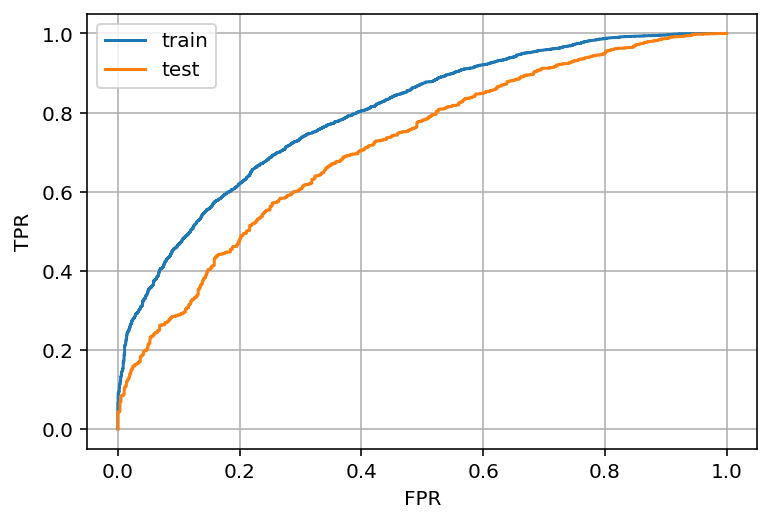

In [64]:
y_pred_xgb_test = clf_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_train = clf_xgb.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_xgb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_xgb_test, 'test')
plt.grid()
plt.legend();

#### Online scoring

In [65]:
params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1,
          'n_jobs': -1}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.70047	validation_1-auc:0.67524
[1]	validation_0-auc:0.71894	validation_1-auc:0.69057
[2]	validation_0-auc:0.72290	validation_1-auc:0.69677
[3]	validation_0-auc:0.72567	validation_1-auc:0.69514
[4]	validation_0-auc:0.72365	validation_1-auc:0.68986
[5]	validation_0-auc:0.72059	validation_1-auc:0.68954
[6]	validation_0-auc:0.72748	validation_1-auc:0.69571
[7]	validation_0-auc:0.72821	validation_1-auc:0.69704
[8]	validation_0-auc:0.72888	validation_1-auc:0.69804
[9]	validation_0-auc:0.72902	validation_1-auc:0.69637
[10]	validation_0-auc:0.72986	validation_1-auc:0.69618
[11]	validation_0-auc:0.73090	validation_1-auc:0.70013
[12]	validation_0-auc:0.73320	validation_1-auc:0.70319
[13]	validation_0-auc:0.73350	validation_1-auc:0.70328
[14]	validation_0-auc:0.73475	validation_1-auc:0.70592
[15]	validation_0-auc:0.73698	validation_1-auc:0.70790
[16]	validation_0-auc:0.73728	validation_1-auc:0.70711
[17]	validation_0-auc:0.73868	validation_1-auc:0.70930
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Statring params

In [66]:
%%time

params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_jobs': -1}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.73062	validation_1-auc:0.68394
[1]	validation_0-auc:0.74843	validation_1-auc:0.69272
[2]	validation_0-auc:0.75884	validation_1-auc:0.69745
[3]	validation_0-auc:0.76634	validation_1-auc:0.70023
[4]	validation_0-auc:0.76797	validation_1-auc:0.70234
[5]	validation_0-auc:0.77185	validation_1-auc:0.70158
[6]	validation_0-auc:0.77585	validation_1-auc:0.70140
[7]	validation_0-auc:0.77655	validation_1-auc:0.70112
[8]	validation_0-auc:0.78195	validation_1-auc:0.70446
[9]	validation_0-auc:0.78339	validation_1-auc:0.70533
[10]	validation_0-auc:0.78497	validation_1-auc:0.70590
[11]	validation_0-auc:0.78802	validation_1-auc:0.70326
[12]	validation_0-auc:0.78937	validation_1-auc:0.70289
[13]	validation_0-auc:0.79252	validation_1-auc:0.70553
[14]	validation_0-auc:0.79535	validation_1-auc:0.70726
[15]	validation_0-auc:0.79744	validation_1-auc:0.70449
[16]	validation_0-auc:0.80045	validation_1-auc:0.70443
[17]	validation_0-auc:0.80256	validation_1-auc:0.70493
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

###### Let's get the lists of metrics results by iteration from the clf_xgb object, build graphs

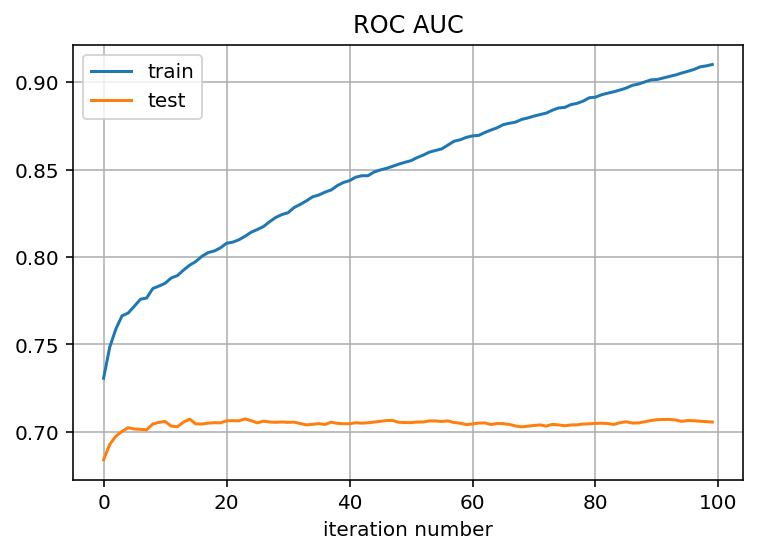

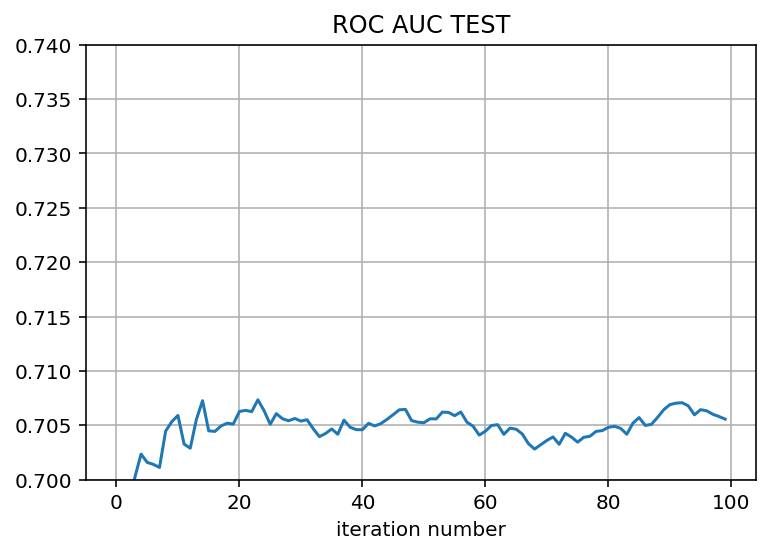

In [67]:
def save_online_metric(clf):
    return pd.DataFrame({'train': clf.evals_result()['validation_0']['auc'],
                         'test': clf.evals_result()['validation_1']['auc']})
res = save_online_metric(clf_xgb)
res.plot(title='ROC AUC')
plt.xlabel('iteration number')
plt.grid();
plt.figure()
res.test.plot(ylim=(0.7, 0.74), title='ROC AUC TEST')
plt.xlabel('iteration number')
plt.grid();

###### We need to overcome overfitting, decrease the learning_rate. We will also reduce the number of trees to speed up learning.

In [68]:
%%time
params = {'n_estimators': 50,
          'learning_rate': 0.03,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_jobs': -1}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

best_params = params

[0]	validation_0-auc:0.73062	validation_1-auc:0.68394
[1]	validation_0-auc:0.74600	validation_1-auc:0.69253
[2]	validation_0-auc:0.75663	validation_1-auc:0.69911
[3]	validation_0-auc:0.76143	validation_1-auc:0.70400
[4]	validation_0-auc:0.76224	validation_1-auc:0.70712
[5]	validation_0-auc:0.76137	validation_1-auc:0.70375
[6]	validation_0-auc:0.76479	validation_1-auc:0.70223
[7]	validation_0-auc:0.76681	validation_1-auc:0.70185
[8]	validation_0-auc:0.77237	validation_1-auc:0.70669
[9]	validation_0-auc:0.77199	validation_1-auc:0.70637
[10]	validation_0-auc:0.77296	validation_1-auc:0.70649
[11]	validation_0-auc:0.77355	validation_1-auc:0.70581
[12]	validation_0-auc:0.77465	validation_1-auc:0.70593
[13]	validation_0-auc:0.77623	validation_1-auc:0.70835
[14]	validation_0-auc:0.77761	validation_1-auc:0.71006
[15]	validation_0-auc:0.77837	validation_1-auc:0.70913
[16]	validation_0-auc:0.77937	validation_1-auc:0.70929
[17]	validation_0-auc:0.78026	validation_1-auc:0.71198
[18]	validation_0-au

### Upgraded GS for ROC AUC

In [69]:
def find_params(clf, param_grid):
    clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=[(np.arange(len(X_train)),
                                                               np.arange(len(X_test)) + len(X_train))],
                  verbose=3)

    clf.fit(pd.concat([X_train, X_test]).values, pd.concat([y_train, y_test]).values)
    best_params = clf.best_estimator_.get_params()
    print('Best test ROC AUC: ', clf.best_score_)
    print('Best params: ', best_params)
    return best_params

**Parameter selection process **:

1. Let's fix the learning_rate and n_estimators so that the model doesn't get retrained during iterations
2. Adjust the tree parameters: max_depth and min_child_weight
3. Configuring gamma (optional)
4. Configuring subsample and colsample_bytree
5. Set up regularization reg_lambda and reg_alpha
6. Decrease learning_rate, increase the number of trees and train again using the best parameters

####  max_depth and min_child_weight

In [70]:
%%time

from sklearn.model_selection import GridSearchCV

clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'max_depth': [3, 5, 10],
    'min_child_weight': [10, 20, 100]#[1, 5, 10]
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[14:06:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END ...............max_depth=3, min_child_weight=10; total time=   1.5s
[14:06:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END ...............max_depth=3, min_child_weight=20; total time=   0.9s
[14:06:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric 

#### gamma

In [71]:
%%time

clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'gamma': np.linspace(0, 0.5, 5)
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[14:07:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END ......................................gamma=0.0; total time=   3.1s
[14:07:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END ....................................gamma=0.125; total time=   2.3s
[14:07:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric 

#### subsample and colsample_bytree

In [72]:
%%time
clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'subsample': np.linspace(0.5, 1, 6),
    'colsample_bytree': np.linspace(0.5, 1, 6)
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
[14:07:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END ............colsample_bytree=0.5, subsample=0.5; total time=   2.0s
[14:07:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END ............colsample_bytree=0.5, subsample=0.6; total time=   1.5s
[14:07:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metri

[CV 1/1] END ............colsample_bytree=0.8, subsample=0.8; total time=   2.3s
[14:08:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END ............colsample_bytree=0.8, subsample=0.9; total time=   3.1s
[14:08:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END ............colsample_bytree=0.8, subsample=1.0; total time=   3.1s
[14:08:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the defa

#### reg_lambda  reg_alpha

In [73]:
%%time

clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'reg_alpha': [0, 0.0001, 0.001, 0.1, 1],
    'reg_lambda': [0, 0.0001, 0.001, 0.1, 1]
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 25 candidates, totalling 25 fits
[14:08:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END ......................reg_alpha=0, reg_lambda=0; total time=   2.8s
[14:09:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END .................reg_alpha=0, reg_lambda=0.0001; total time=   2.7s
[14:09:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metri

[14:09:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END .................reg_alpha=1, reg_lambda=0.0001; total time=   1.8s
[14:09:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END ..................reg_alpha=1, reg_lambda=0.001; total time=   1.9s
[14:09:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 

#### decreasing learning_rate

In [74]:
%%time

best_params['learning_rate'] = 0.01
best_params['n_estimators'] = 500

clf_xgb = xgb.XGBClassifier(**best_params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.68391	validation_1-auc:0.66268
[1]	validation_0-auc:0.72988	validation_1-auc:0.69709
[2]	validation_0-auc:0.74298	validation_1-auc:0.70518
[3]	validation_0-auc:0.74975	validation_1-auc:0.70847
[4]	validation_0-auc:0.74930	validation_1-auc:0.70743
[5]	validation_0-auc:0.74972	validation_1-auc:0.70830
[6]	validation_0-auc:0.75148	validation_1-auc:0.70626
[7]	validation_0-auc:0.75222	validation_1-auc:0.70790
[8]	validation_0-auc:0.75429	validation_1-auc:0.71053
[9]	validation_0-auc:0.75513	validation_1-auc:0.71055
[10]	validation_0-auc:0.75629	validation_1-auc:0.71060
[11]	validation_0-auc:0.75628	validation_1-auc:0.71167
[12]	validation_0-auc:0.75608	validation_1-auc:0.71114
[13]	validation_0-auc:0.75735	validation_1-auc:0.71359
[14]	validation_0-auc:0.75723	validation_1-auc:0.71459
[15]	validation_0-auc:0.75792	validation_1-auc:0.71445
[16]	validation_0-auc:0.75866	validation_1-auc:0.71462
[17]	validation_0-auc:0.75836	validation_1-auc:0.71505
[18]	validation_0-au

[149]	validation_0-auc:0.77444	validation_1-auc:0.71573
[150]	validation_0-auc:0.77460	validation_1-auc:0.71590
[151]	validation_0-auc:0.77468	validation_1-auc:0.71606
[152]	validation_0-auc:0.77475	validation_1-auc:0.71607
[153]	validation_0-auc:0.77482	validation_1-auc:0.71584
[154]	validation_0-auc:0.77503	validation_1-auc:0.71581
[155]	validation_0-auc:0.77512	validation_1-auc:0.71592
[156]	validation_0-auc:0.77507	validation_1-auc:0.71596
[157]	validation_0-auc:0.77518	validation_1-auc:0.71591
[158]	validation_0-auc:0.77529	validation_1-auc:0.71609
[159]	validation_0-auc:0.77554	validation_1-auc:0.71623
[160]	validation_0-auc:0.77561	validation_1-auc:0.71615
[161]	validation_0-auc:0.77574	validation_1-auc:0.71612
[162]	validation_0-auc:0.77601	validation_1-auc:0.71632
[163]	validation_0-auc:0.77613	validation_1-auc:0.71638
[164]	validation_0-auc:0.77626	validation_1-auc:0.71620
[165]	validation_0-auc:0.77630	validation_1-auc:0.71616
[166]	validation_0-auc:0.77644	validation_1-auc:

[296]	validation_0-auc:0.79015	validation_1-auc:0.71622
[297]	validation_0-auc:0.79025	validation_1-auc:0.71623
[298]	validation_0-auc:0.79043	validation_1-auc:0.71626
[299]	validation_0-auc:0.79056	validation_1-auc:0.71630
[300]	validation_0-auc:0.79075	validation_1-auc:0.71635
[301]	validation_0-auc:0.79078	validation_1-auc:0.71639
[302]	validation_0-auc:0.79084	validation_1-auc:0.71648
[303]	validation_0-auc:0.79088	validation_1-auc:0.71644
[304]	validation_0-auc:0.79100	validation_1-auc:0.71646
[305]	validation_0-auc:0.79101	validation_1-auc:0.71643
[306]	validation_0-auc:0.79109	validation_1-auc:0.71653
[307]	validation_0-auc:0.79126	validation_1-auc:0.71653
[308]	validation_0-auc:0.79141	validation_1-auc:0.71668
[309]	validation_0-auc:0.79155	validation_1-auc:0.71668
[310]	validation_0-auc:0.79162	validation_1-auc:0.71664
[311]	validation_0-auc:0.79176	validation_1-auc:0.71642
[312]	validation_0-auc:0.79194	validation_1-auc:0.71634
[313]	validation_0-auc:0.79212	validation_1-auc:

[443]	validation_0-auc:0.80599	validation_1-auc:0.71623
[444]	validation_0-auc:0.80603	validation_1-auc:0.71617
[445]	validation_0-auc:0.80616	validation_1-auc:0.71608
[446]	validation_0-auc:0.80631	validation_1-auc:0.71597
[447]	validation_0-auc:0.80636	validation_1-auc:0.71605
[448]	validation_0-auc:0.80651	validation_1-auc:0.71598
[449]	validation_0-auc:0.80666	validation_1-auc:0.71596
[450]	validation_0-auc:0.80671	validation_1-auc:0.71597
[451]	validation_0-auc:0.80682	validation_1-auc:0.71603
[452]	validation_0-auc:0.80690	validation_1-auc:0.71612
[453]	validation_0-auc:0.80693	validation_1-auc:0.71606
[454]	validation_0-auc:0.80704	validation_1-auc:0.71603
[455]	validation_0-auc:0.80710	validation_1-auc:0.71601
[456]	validation_0-auc:0.80720	validation_1-auc:0.71609
[457]	validation_0-auc:0.80731	validation_1-auc:0.71606
[458]	validation_0-auc:0.80744	validation_1-auc:0.71603
[459]	validation_0-auc:0.80746	validation_1-auc:0.71608
[460]	validation_0-auc:0.80755	validation_1-auc:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.375, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=20, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

###### Visualizing the metric depending on the iteration

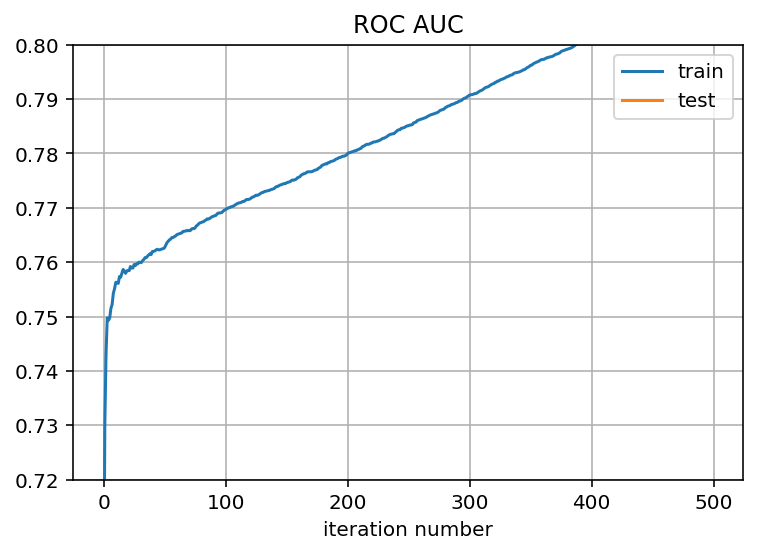

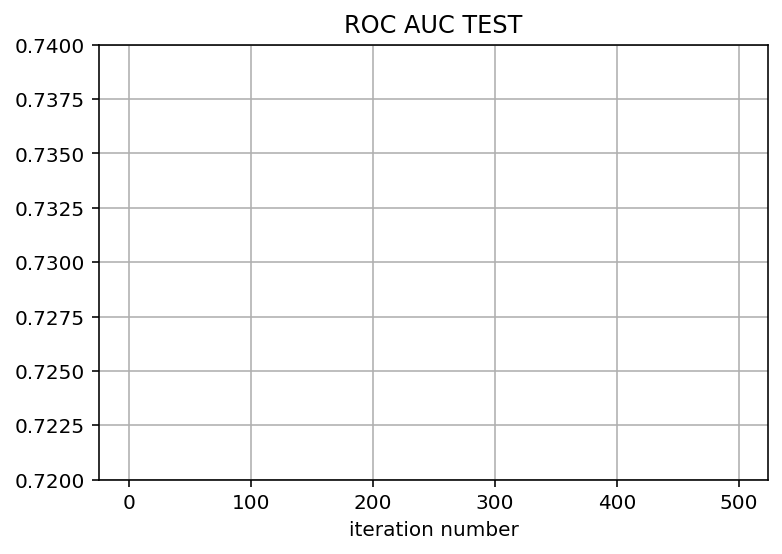

In [75]:
res = save_online_metric(clf_xgb)
res.plot(ylim=(0.72, 0.8), title='ROC AUC')
plt.xlabel('iteration number')
plt.grid();
plt.figure()
res.test.plot(ylim=(0.72, 0.74), title='ROC AUC TEST')
plt.xlabel('iteration number')
plt.grid();

### HyperOpt

http://hyperopt.github.io/hyperopt/

Tool for automatic smart optimization of a large number of hyperparameters. Uses the Tree of Parzen Estimators algorithm.

The main idea of the hyperopt library is to construct a mathematical hypothesis about how the result function looks for a set of parameters and to test this hypothesis with each iteration.

In [76]:
%%time

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

#функция, которую будем МИНИМИЗИРОВАТЬ
def score(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_jobs'] = -1
    print("Training with params : ", params)
    clf = xgb.XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred_xgb_test = clf.predict_proba(X_test)[:, 1]
    auc = calc_auc(y_test, y_pred_xgb_test, prin=False)
    result = {'loss': 1-auc, 'status': STATUS_OK}
    print('TEST ROC AUC: {0:.4f}'.format(auc))
    return result



space = {'max_depth' : hp.quniform('max_depth', 1, 10, 1),
         'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
         'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
         'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
         'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
         'silent' : 1,
         'n_estimators': 100,
         'learning_rate': 0.1
         }
trials = Trials()

best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=20)

Training with params :                                                                                                 
{'colsample_bytree': 0.8, 'gamma': 0.8500000000000001, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 8.0, 'n_estimators': 100, 'silent': 1, 'subsample': 0.65, 'n_jobs': -1}
[14:10:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541:                   
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:10:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore t

{'colsample_bytree': 0.75, 'gamma': 0.6000000000000001, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 3.0, 'n_estimators': 100, 'silent': 1, 'subsample': 0.5, 'n_jobs': -1}
[14:10:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541:                   
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:10:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TEST ROC AUC: 0.7122                                                                                   

[14:11:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541:                   
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:11:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TEST ROC AUC: 0.7024                                                                                                   
Training with params :                                                                                                 
{'colsample_bytree': 0.6000000000000001, 'gamma'

In [77]:
best

{'colsample_bytree': 0.8,
 'gamma': 0.65,
 'max_depth': 2.0,
 'min_child_weight': 8.0,
 'subsample': 0.9}

In [78]:
trials.best_trial

{'state': 2,
 'tid': 4,
 'spec': None,
 'result': {'loss': 0.2831839056444543, 'status': 'ok'},
 'misc': {'tid': 4,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'colsample_bytree': [4],
   'gamma': [4],
   'max_depth': [4],
   'min_child_weight': [4],
   'subsample': [4]},
  'vals': {'colsample_bytree': [0.8],
   'gamma': [0.65],
   'max_depth': [2.0],
   'min_child_weight': [8.0],
   'subsample': [0.9]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 2, 2, 11, 10, 37, 563000),
 'refresh_time': datetime.datetime(2021, 2, 2, 11, 10, 40, 193000)}

#### build with best

In [79]:
best_new = {'colsample_bytree': 0.75,
 'gamma': 0.75,
 'max_depth': 3,
 'min_child_weight': 3.0,
 'subsample': 0.6000000000000001,
 'n_estimators': 100,
 'learning_rate': 0.1         
}

In [80]:
%%time
clf_xgb = xgb.XGBClassifier(**best_new)
clf_xgb.fit(X_train, y_train)

[14:11:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 2.48 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0.75, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.6000000000000001, tree_method='exact',
              validate_parameters=1, verbosity=None)

Train:
ROC AUC: 0.8048
Test:
ROC AUC: 0.7056


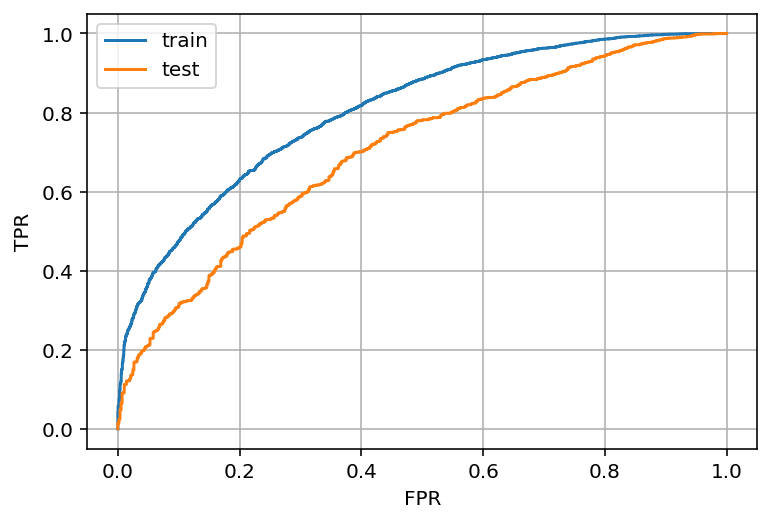

In [81]:
y_pred_xgb_test = clf_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_train = clf_xgb.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_xgb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_xgb_test, 'test')
plt.grid()
plt.legend();

### Feature importantce

#### Built-in methods

You need to pull out the original object of the xgboost.core.Booster class from the sklearn wrapper

There are 3 types of severity in get_score ():

     weight - total number of times when the feature was used to split the vertex
     gain - average gain in quality when the feature was used to split the top
     cover - the average number of objects that fell into the split by feature when it was used to split the vertex

Wall time: 257 ms


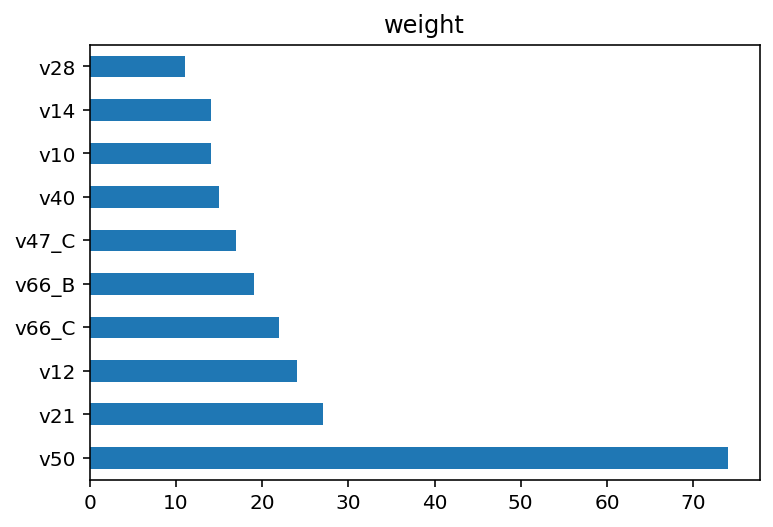

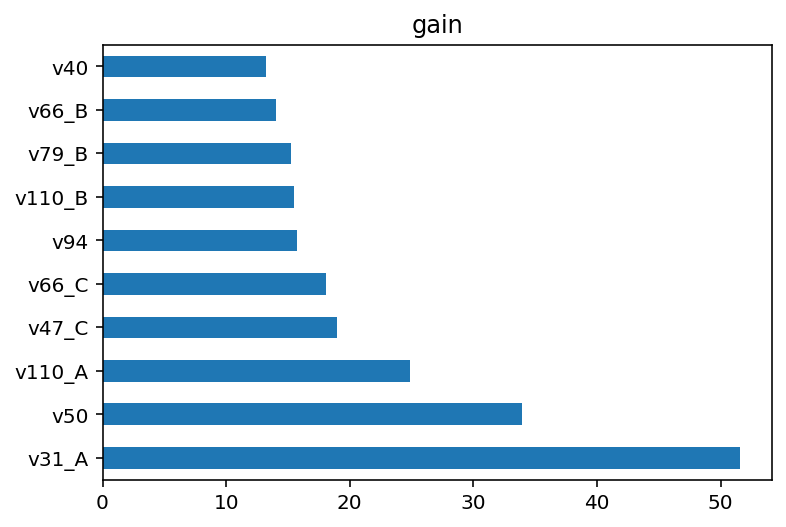

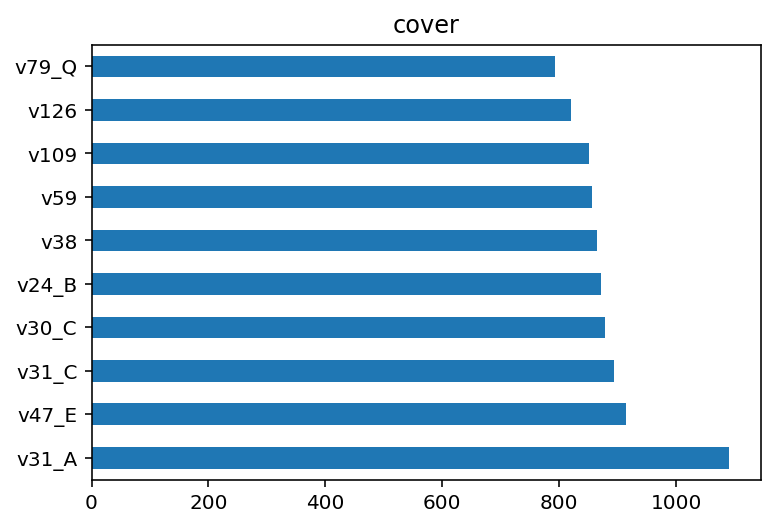

In [82]:
%%time

bst = clf_xgb.get_booster()

for kind in ['weight', 'gain', 'cover']:
    imp = pd.Series(bst.get_score(importance_type=kind))
    plt.figure()
    imp.sort_values(ascending=False).iloc[:10].plot(kind='barh', title=kind)

#### XGBFI

Allows you to evaluate the importance of the interaction of signs

https://github.com/limexp/xgbfir

In [84]:
import xgbfir
xgbfir.saveXgbFI(clf_xgb, OutputXlsxFile='xgbfi_report.xlsx')

In [85]:
pd.read_excel('xgbfi_report.xlsx', sheet_name=0)

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,v50,2513.479993,74,50.311779,0.679889,33.965946,2130.159113,1,1,1,11,2,1,2.833333,30.054054,0.959459
1,v66_C,397.668200,22,14.876853,0.676221,18.075827,253.573289,2,4,2,12,5,3,4.666667,23.500000,1.090909
2,v47_C,322.405757,17,9.379013,0.551707,18.965045,186.398792,3,6,4,22,4,4,7.166667,13.764706,1.529412
3,v31_A,309.518412,6,5.573126,0.928854,51.586402,297.473730,4,21,11,4,1,2,7.166667,10.166667,0.166667
4,v66_B,266.300944,19,6.424915,0.338153,14.015839,89.374231,5,5,6,63,8,7,15.666667,27.526316,1.578947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,v69,16.206783,3,0.853217,0.284406,5.402261,5.381862,96,84,77,72,100,87,86.000000,45.000000,1.666667
96,v54,15.913864,2,0.213551,0.106775,7.956932,1.269522,97,97,95,93,67,96,90.833333,55.500000,1.500000
97,v45,15.843583,2,0.239734,0.119867,7.921792,2.197183,98,98,93,90,69,92,90.000000,54.500000,1.500000
98,v81,15.828932,2,0.035261,0.017630,7.914466,0.278843,99,99,100,100,70,100,94.666667,47.000000,2.000000


## CatBoost

In [86]:
from catboost import CatBoostClassifier, Pool

In [87]:
train_data = X_train
train_labels = y_train
eval_data = X_test
eval_labels = y_test
eval_dataset = Pool(eval_data,
                    eval_labels)





clf_catb = CatBoostClassifier(
                           l2_leaf_reg=4000,
                           iterations=1000,
                           learning_rate=0.3,
                           eval_metric='AUC',
                            max_depth=7,
                           loss_function='CrossEntropy',
                           use_best_model=True,
                           custom_metric=['Accuracy',
                                          'AUC:hints=skip_train~false'],
                                                     )

In [88]:
clf_catb.fit(train_data,
          train_labels,
          eval_set=eval_dataset,
          verbose=False,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train:
ROC AUC: 0.8158
Test:
ROC AUC: 0.7142


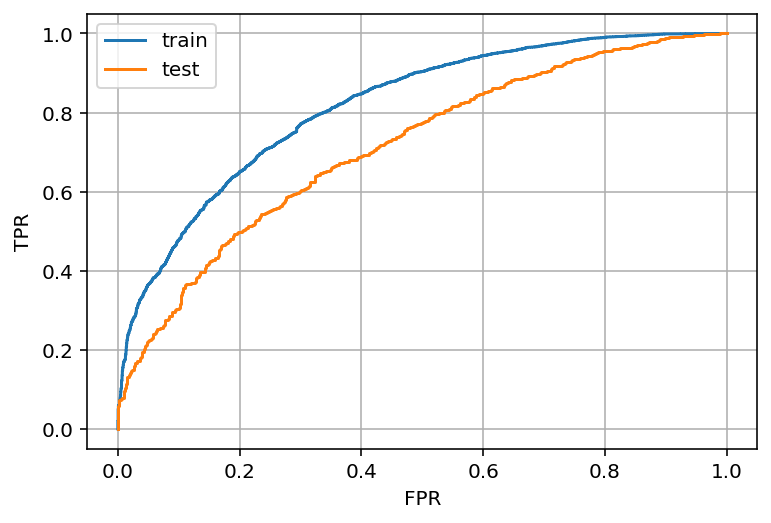

In [89]:
y_pred_catb_test = clf_catb.predict_proba(X_test)[:, 1]
y_pred_catb_train = clf_catb.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_catb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_catb_test, 'test')
plt.grid()
plt.legend();